# Día 6: Modelos Supervisados en Series Temporales - Práctica

En este notebook haremos:
1. Preparación de datos (feature engineering con lags, calendarios).
2. Entrenamiento de modelos supervisados (Random Forest, Gradient Boosting).
3. Clustering simple con K-Means y, opcionalmente, DTW.
4. Breve demo de LSTM (si el tiempo lo permite).


In [2]:
# Sección 0: Importaciones
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, accuracy_score

# Para LSTM (opcional, con tensorflow/keras o pytorch):
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

%matplotlib inline
sns.set_style("whitegrid")

print("Entorno de trabajo configurado.")

Entorno de trabajo configurado.


## Sección 1: Carga (o creación) de datos

Puedes usar un dataset real (ej. ventas, energía, tráfico, etc.) o generar datos sintéticos con estacionalidad.


In [3]:
# Datos sintéticos (ej. diarios con ~1 año)
np.random.seed(42)
dates = pd.date_range("2025-01-01", "2026-01-01", freq="D")
n = len(dates)

trend = np.linspace(50, 100, n)
seasonality = 10 * np.sin(2 * np.pi * np.arange(n) / 7)  # estacionalidad semanal
noise = np.random.normal(0, 5, n)

consumo = trend + seasonality + noise

df = pd.DataFrame({"fecha": dates, "consumo": consumo})
df.set_index("fecha", inplace=True)
df.head()


,consumo
fecha,
2025-01-01,52.483571
2025-01-02,57.263980
2025-01-03,63.261694
2025-01-04,62.364946
2025-01-05,45.038341


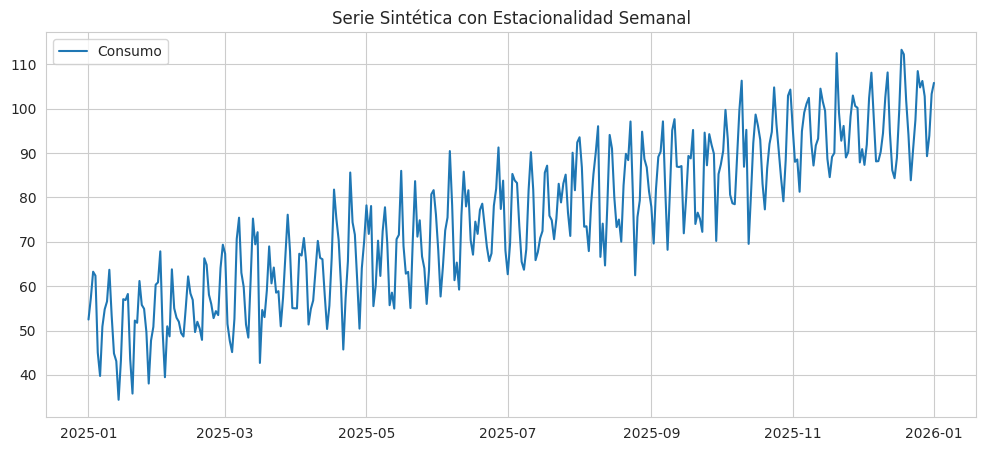

In [4]:
# Visualización inicial
plt.figure(figsize=(12,5))
plt.plot(df.index, df["consumo"], label="Consumo")
plt.title("Serie Sintética con Estacionalidad Semanal")
plt.legend()
plt.show()


## Sección 2: Feature Engineering para Modelo Supervisado

- Creamos lags, variables de calendario, etc.
- Dividimos en train/test en el tiempo.


In [5]:
df_feat = df.copy()
df_feat["lag1"] = df_feat["consumo"].shift(1)
df_feat["lag2"] = df_feat["consumo"].shift(2)

# Variables de calendario (día de la semana)
df_feat["day_of_week"] = df_feat.index.dayofweek

# Eliminamos NaN por lag
df_feat.dropna(inplace=True)

# Split train/test (ejemplo ~80% train)
train_size = int(len(df_feat)*0.8)
train_data = df_feat.iloc[:train_size]
test_data = df_feat.iloc[train_size:]

X_train = train_data.drop("consumo", axis=1)
y_train = train_data["consumo"]
X_test = test_data.drop("consumo", axis=1)
y_test = test_data["consumo"]


## Sección 3: Entrenamiento de un Modelo Supervisado (Random Forest)

### 3.1 Random Forest Regressor


Random Forest MSE: 106.31009779028402


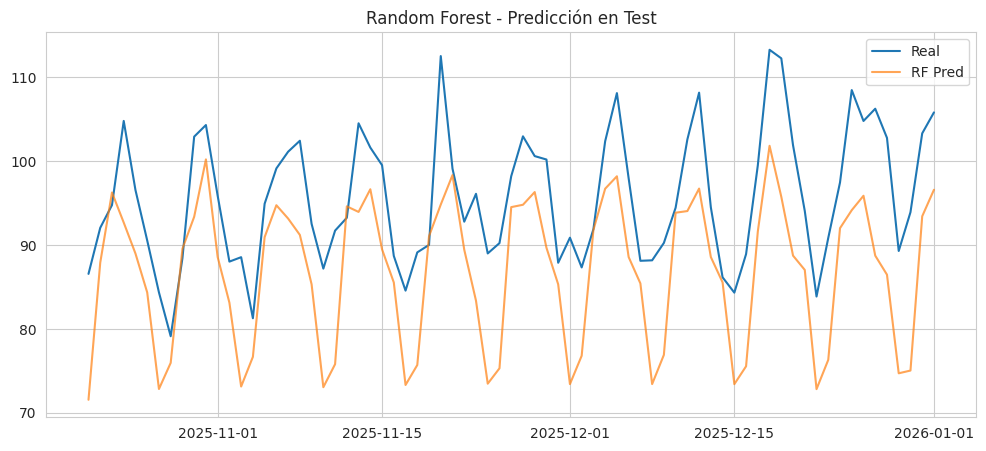

In [6]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

y_pred_rfr = rfr.predict(X_test)

mse_rfr = mean_squared_error(y_test, y_pred_rfr)
print("Random Forest MSE:", mse_rfr)

# Gráfico comparativo
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Real")
plt.plot(y_test.index, y_pred_rfr, label="RF Pred", alpha=0.7)
plt.title("Random Forest - Predicción en Test")
plt.legend()
plt.show()


**Comentarios**:
- Revisa cómo se ajusta el pronóstico.  
- Puedes probar *GradientBoostingRegressor* igual.

---
## Sección 4: Clustering de Series Temporales

Ejemplo: Queremos agrupar *subsecuencias* de 7 días cada una o comparar *series de diferentes entidades*.  

Aquí, usaremos K-Means sobre vectores de 7 días, a modo didáctico.


In [7]:
# Ejemplo de subsecuencias de 7 días
window_size = 7
subseq = []

for i in range(len(df) - window_size + 1):
    subseq.append(df["consumo"].iloc[i:i+window_size].values)

subseq = np.array(subseq)  # shape: (n_subseq, 7)

# K-Means con 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(subseq)

labels = kmeans.labels_
print("Etiquetas de clúster:", np.unique(labels, return_counts=True))


Etiquetas de clúster: (array([0, 1, 2], dtype=int32), array([129, 117, 114]))


**Comentarios**:
- Cada subsecuencia de 7 días se considera un "vector de 7 dimensiones".  
- K-Means agrupa subsecuencias parecidas.  

(Opcional) Podrías usar DTW en lugar de la distancia euclidiana, pero requiere librerías específicas como `dtaidistance` o `tslearn`.

---
## Sección 5: Introducción Práctica a LSTM (Opcional)

Mostraremos solo un ejemplo muy sencillo con Keras.


In [8]:
# Preparamos datos en formato supervised (X, y) para LSTM, usando lag de 1
df_lstm = df.copy()
df_lstm["lag1"] = df_lstm["consumo"].shift(1)
df_lstm.dropna(inplace=True)

# Normalización
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_lstm), index=df_lstm.index, columns=df_lstm.columns)

# Definimos X, y
X_all = df_scaled[["lag1"]].values
y_all = df_scaled["consumo"].values

# Convertimos a formato [samples, time_steps, features]
X_all = X_all.reshape(X_all.shape[0], 1, 1)

# Split train/test
train_size = int(0.8 * len(X_all))
X_train_lstm, X_test_lstm = X_all[:train_size], X_all[train_size:]
y_train_lstm, y_test_lstm = y_all[:train_size], y_all[train_size:]

# Definimos la red LSTM
model = Sequential()
model.add(LSTM(16, input_shape=(1,1)))
model.add(Dense(1))  # salida

model.compile(optimizer='adam', loss='mse')

# Entrenamiento rápido
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=8, validation_split=0.1, verbose=0)

# Predicciones
y_pred_lstm = model.predict(X_test_lstm)


2025-02-03 10:28:31.327389: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/caumel/anaconda3/envs/time_series_course/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


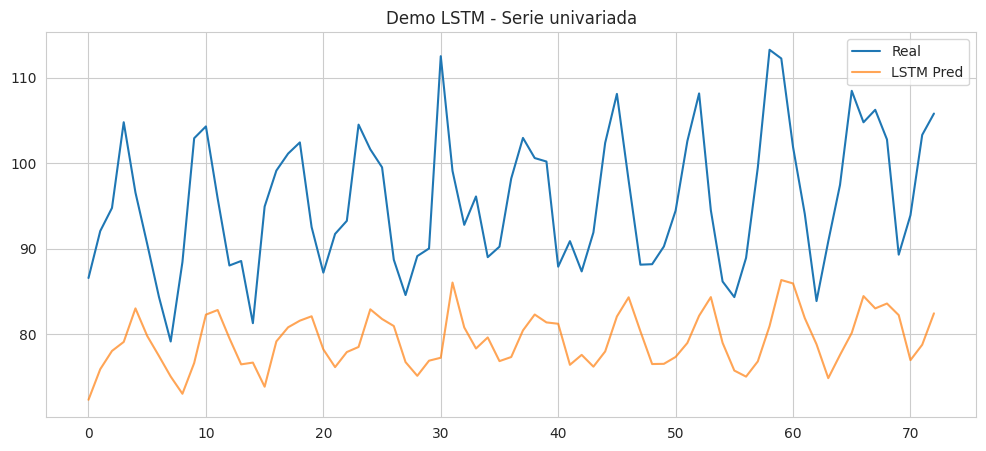

In [9]:
# Invertimos la escala para ver valores reales
# y_test_lstm -> shape: (num_samples,)
# y_pred_lstm -> shape: (num_samples, 1)

y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test_lstm, y_test_lstm]))[:,0]
y_pred_rescaled = scaler.inverse_transform(np.column_stack([y_pred_lstm[:,0], y_pred_lstm[:,0]]))[:,0]

plt.figure(figsize=(12,5))
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label="Real")
plt.plot(range(len(y_pred_rescaled)), y_pred_rescaled, label="LSTM Pred", alpha=0.7)
plt.title("Demo LSTM - Serie univariada")
plt.legend()
plt.show()


**Comentarios**:
- Este ejemplo es muy básico (solo 1 lag, 1 feature).  
- En casos reales, se usan secuencias más largas y más neuronas.

---
## Sección 6: Tarea

1. **Probar** distintos modelos (RF, XGBoost, etc.) con su dataset.  
2. **Clustering**: a) Agrupar series completas (distintas entidades). b) O subsecuencias con K-Means o DTW.  
3. (Opcional) **Implementar** un ejemplo LSTM con más lags/features.  
4. Documentar y comparar resultados.

¡Fin del Notebook!